# Cooling of the oceanic lithosphere

**Goal:** Implement the half-space cooling model and compare its predictions to observations of heat flow, lithosphere age, and bathymetry.

The **half-space cooling model** simulates the cooling of the oceanic lithosphere as it moves away from the mid-ocean ridges where it's formed (due to  seafloor spreading).

<img style="width: 700px; margin: 10px auto;" src="https://raw.githubusercontent.com/leouieda/lithosphere/bb86251c0934b0df98c32181788fdc76472aa4b5/lectures/assets/halfspace-model-time.svg">
<p style="text-align: left; width: 700px; max-width: 100%; margin: 30px auto;">
Figure caption: Sketch of the half-space cooling model setup. The lithosphere-asthenosphere boundary (LAB) is marked by an isotherm. The ridge is at the origin and the plates spread symmetrically with constant velocity $u$.
</p>

The cooling happens by vertical condution of heat to the water layer and can be modelled by the 1D diffusion equation:

$$
\dfrac{\partial^2 T}{\partial z^2}
= \dfrac{1}{\alpha} \dfrac{\partial T}{\partial t}
$$


The solution to this equation, given the starting condition of the temperature being equal to the asthenosphere temperature $T(z, t=0) = T_a$ and boundary condition of the temperature at the surface being constant $T(z=0, t) = T_0$, is:

$$
T(z, t) = T_0 + (T_a - T_0)\ \text{erf}
\left(
\dfrac{z}{2\sqrt{\alpha t}}
\right)
$$

in which $\alpha$ is the thermal diffusivity of the lithosphere, $t$ is the age of the lithosphere, $z$ is the depth, and $\text{erf}$ is the error function.

From this equation, we can apply Fourier's law to get **heat flow at the surface**:

$$
\ q_0(t) = k \dfrac{T_a - T_0}{\sqrt{\pi \alpha t}}
$$

where $k$ is the thermal conductivity of the lithosphere.

We can also apply the conditions for isostatic equilibrium (since we know that the oceanic lithosphere is largely in equilibrium from gravity disturbance data) to predict **bathymetry** from the half-space cooling model:

$$
w(t) = w_r + \dfrac{2 \rho_a \alpha_V (T_a - T_0)}{\rho_a - \rho_w}
\sqrt{\dfrac{\alpha t}{\pi}}
$$

in which $w_r$ is the bathymetric depth at the ridge, $\rho_a$ is the density of the asthenosphere, $\rho_w$ is the density of water, and $\alpha_V$ is the coefficient of thermal expansion of the lithosphere.

**Our job now is to code the equations for bathymetry and surface heat flow in Python**.

## The data

**Download:** [global-geophysical-data.nc](https://github.com/leouieda/lithosphere/raw/main/data/global-geophysical-data.nc) (place it in the **same folder** as this notebook)

The data grids are stored in a [netCDF](https://en.wikipedia.org/wiki/NetCDF) file, which is a very common standard for storing and distributing gridded data. It's used throughout the Earth, ocean, and climate sciences and can be read an manipulated with most software platforms. It contains global grids of gravity, topography, and heat flow. All grids were interpolated onto the same resolution of 0.2 degrees (a compromise between resolution and size of the file) so that we can easily compare and use all of the data together.

* **Gravity**: generated from the [EIGEN-6C4 spherical harmonic model](https://doi.org/10.5880/icgem.2015.1) through the [ICGEM webservice](http://icgem.gfz-potsdam.de/home). It includes two grids: the gravity disturbance calculated with the WGS84 ellipsoid and the Bouguer gravity disturbance calculated using a topography density of 2670 kg/m³. The data for both grids was generated on top of the Earth's surface (the water surface in the oceans and topography on land).
* **Topography and bathymetry**: a downsampled version of [ETOPO1](https://doi.org/10.7289/V5C8276M) and includes a version smoothed using a Gaussian filter with 1 degree width (~100 km).
* **Heat flow**: an upsampled version of the compilation by [Lucazeau (2019)](https://doi.org/10.1029/2019GC008389) (originally 0.5 degree resolution).
* **Lithosphere age (oceanic)**: a downsampled version of the grid by [Müller et al. (2008)](https://doi.org/10.1029/2007GC001743) (originally 6 arc-minutes).

## Import the required libraries

Load the required software to load the data, make maps, and perform calculations.

In [1]:
# For arrays and linear algebra
import numpy as np
# To make figures and maps
import matplotlib.pyplot as plt
# To load and manipulate grids
import xarray as xr

## Load the data grids

Once again, we'll use xarray to load the data from the netCDF file.

In [2]:
data = xr.load_dataset("global-geophysical-data.nc")
data

<xarray.Dataset>
Dimensions:              (latitude: 901, longitude: 1800)
Coordinates:
  * latitude             (latitude) float32 -90.0 -89.8 -89.6 ... 89.6 89.8 90.0
  * longitude            (longitude) float32 -180.0 -179.8 ... 179.6 179.8
    height               (latitude, longitude) float32 2.716e+03 ... 15.47
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -27.21 -27.21 ... 24.71
    gravity_bouguer      (latitude, longitude) float32 -331.2 -331.2 ... 312.6
    topography_smoothed  (latitude, longitude) float32 2.796e+03 ... -3.56e+03
    topography           (latitude, longitude) float32 2.716e+03 ... -4.213e+03
    heat_flow            (latitude, longitude) float32 75.2 75.2 ... 84.7 84.7
    lithosphere_age      (latitude, longitude) float32 nan nan ... 55.46 55.46

For this practical, we'll use a subsection of the grid that overlaps with a mid-ocean ridge in the South Pacific (a large section around the island of [Rapa Nui](https://en.wikipedia.org/wiki/Easter_Island)).

In [3]:
pacific = data.sel(longitude=slice(-170, -80), latitude=slice(-65, -10))
pacific 

<xarray.Dataset>
Dimensions:              (latitude: 276, longitude: 451)
Coordinates:
  * latitude             (latitude) float32 -65.0 -64.8 -64.6 ... -10.2 -10.0
  * longitude            (longitude) float32 -170.0 -169.8 ... -80.2 -80.0
    height               (latitude, longitude) float32 -50.08 -50.03 ... -0.5685
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -28.45 -28.43 ... -130.9
    gravity_bouguer      (latitude, longitude) float32 172.3 162.2 ... 190.4
    topography_smoothed  (latitude, longitude) float32 -2.919e+03 ... -3.21e+03
    topography           (latitude, longitude) float32 -2.938e+03 ... -4.702e+03
    heat_flow            (latitude, longitude) float32 228.6 155.6 ... 67.9 67.9
    lithosphere_age      (latitude, longitude) float32 4.185 4.22 ... 41.2 nan

We can now plot the observed heat flow, bathymetry, and lithospheric age to see what they look like.

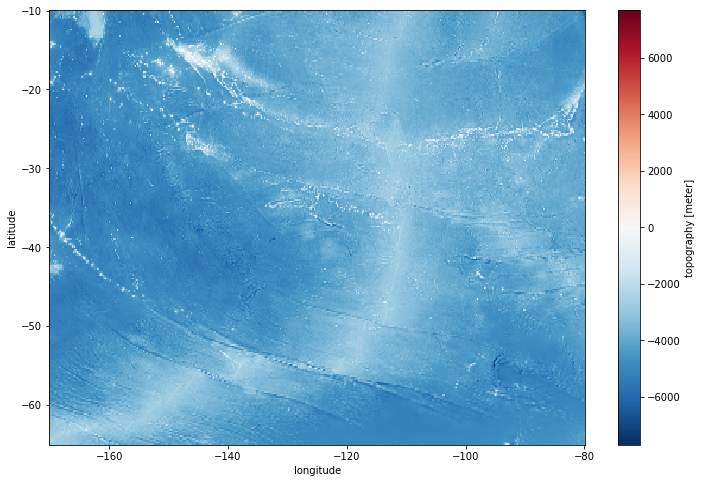

In [4]:
pacific.topography.plot(figsize=(12, 8))

The main mid-ocean ridge is cutting across the area from Southwest to Northeast, marked by several transform faults. You may also notice that there is a separate smaller ridge coming from the East and (almost) connecting with the main ridge to form a triple junction. This is clearer in the heat flow map below.

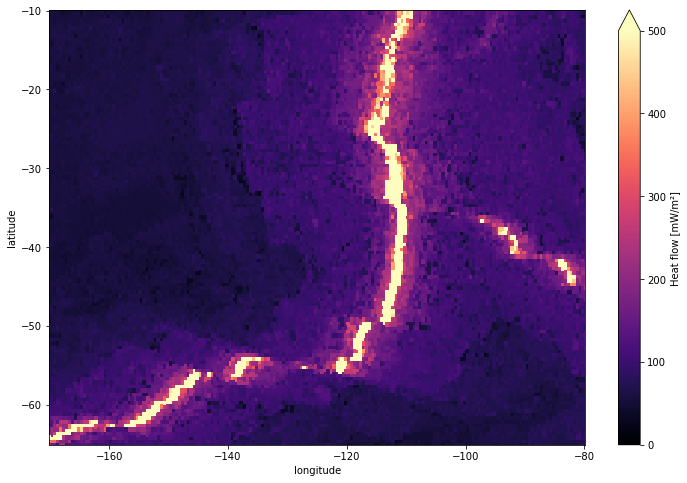

In [5]:
pacific.heat_flow.plot(figsize=(12, 8), vmin=0, vmax=500, cmap="magma")

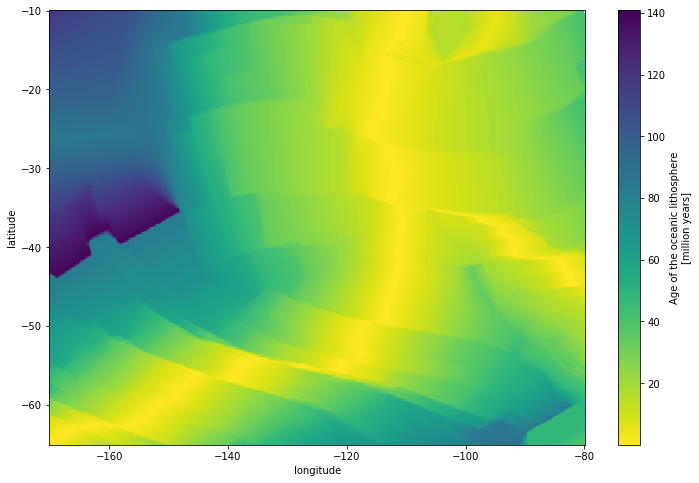

In [6]:
pacific.lithosphere_age.plot(figsize=(12, 8), cmap="viridis_r")

Another useful visualization is to make a point plot of lithosphere age versus bathymetry and heat flow. This is the relationship that we'll be predicting from our half-space cooling model so let's plot it and see what the data look like.

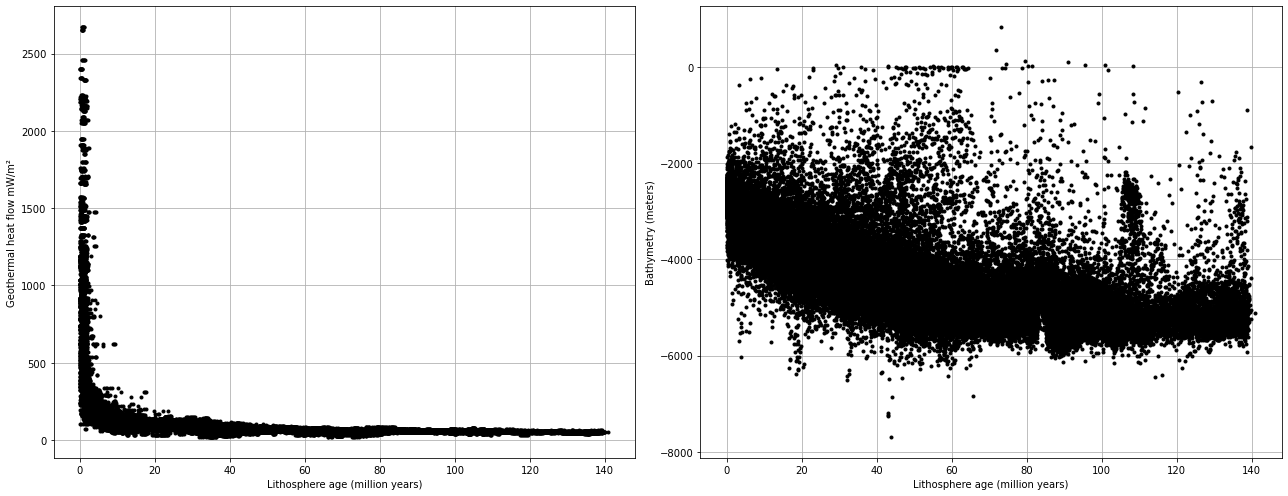

In [7]:
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.plot(pacific.lithosphere_age.values.ravel(), pacific.heat_flow.values.ravel(), ".k")
plt.xlabel("Lithosphere age (million years)")
plt.ylabel("Geothermal heat flow mW/m²")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(pacific.lithosphere_age.values.ravel(), pacific.topography.values.ravel(), ".k")
plt.xlabel("Lithosphere age (million years)")
plt.ylabel("Bathymetry (meters)")
plt.grid()
plt.tight_layout()

Heat flow decays very rapidily with age while the bathymetry decays more slowly. There is also significant spread in the bathymetry, which is expected because of all the seamounts and small islands that dot the oceans. These features aren't formed from the processes at mid-ocean ridges and aren't supported by isostatic equilibrium so we don't expect them to comform to our model. 

To remove these effects, we can downsample the grids (reduce the number of points) by taking the median value of the data in blocks of a certain size.

> **Important**: This is the recommended way of downsampling gridded data. You **cannot just take every N points** from the grid. This would lead to aliasing effects in the final product. Even this is a bit of an approximation since it doesn't take into account variations is distance between points due to the latitude. But since this is a small area the effects will be negligible.

In [8]:
# Take the median of every 6 points in longitude and latitude.
# Drop any parts of the borders that have less than 6 points.
pacific_coarse = pacific.coarsen(longitude=6, latitude=6, boundary="trim").median()
pacific_coarse

<xarray.Dataset>
Dimensions:              (latitude: 46, longitude: 75)
Coordinates:
  * latitude             (latitude) float32 -64.5 -63.3 -62.1 ... -11.7 -10.5
  * longitude            (longitude) float32 -169.5 -168.3 ... -81.9 -80.7
    height               (latitude, longitude) float32 -48.73 -48.48 ... 1.096
Data variables:
    gravity_disturbance  (latitude, longitude) float32 -24.2 -26.01 ... -15.71
    gravity_bouguer      (latitude, longitude) float32 154.8 160.9 ... 296.7
    topography_smoothed  (latitude, longitude) float32 -2.857e+03 ... -4.387e+03
    topography           (latitude, longitude) float32 -2.642e+03 ... -4.714e+03
    heat_flow            (latitude, longitude) float32 343.6 248.4 ... 76.8
    lithosphere_age      (latitude, longitude) float32 1.105 2.02 ... 40.39

Now we can plot the downsampled version of the data and get a much cleaner trend in both heat flow and bathymetry.

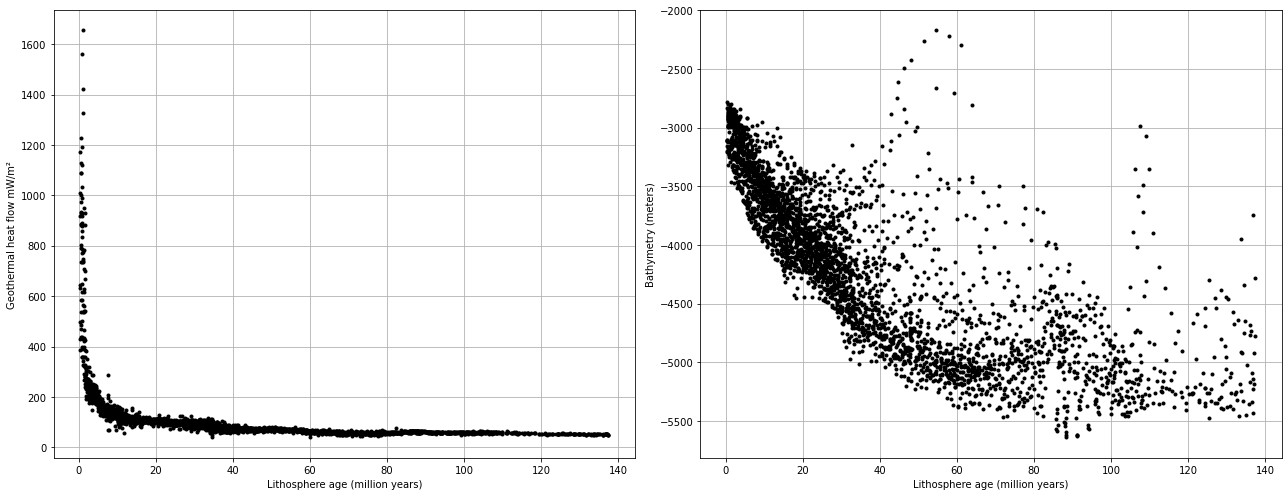

In [9]:
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.plot(pacific_coarse.lithosphere_age.values.ravel(), pacific_coarse.heat_flow.values.ravel(), ".k")
plt.xlabel("Lithosphere age (million years)")
plt.ylabel("Geothermal heat flow mW/m²")
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(pacific_coarse.lithosphere_age.values.ravel(), pacific_coarse.topography_smoothed.values.ravel(), ".k")
plt.xlabel("Lithosphere age (million years)")
plt.ylabel("Bathymetry (meters)")
plt.grid()
plt.tight_layout()

## Heat flow from half-space cooling

Now we can create a function that calculates heat flow at the surface of lithosphere (the bottom the ocean) predicted by the half-space cooling model. As a reminder, this is the equation that we want to calculate:

$$
q_0(t) = k \dfrac{T_a - T_0}{\sqrt{\pi \alpha t}}
$$

An important thing to take into account are the **units of the data and parameters**. In this case, we'll use the following as inputs and outputs:

| Name | Variable | Unit |
|--:|:--:|:--|
| Surface heat flow | $$q_0$$ | $$\frac{mW}{m^2}$$ | 
| Thermal conductivity | $$k$$ | $$\frac{W}{m \cdot K}$$ | 
| Thermal diffusivity | $$\alpha$$ | $$\frac{mm^2}{s}$$ | 
| Age of the lithosphere | $$t$$ | $$myr = 10^6\ \text{years}$$ | 
| Asthenosphere temperature | $$T_a$$ | $$K$$ | 
| Surface temperature | $$T_0$$ | $$K$$ | 

This means that our function is going to have to do some unit conversions in order to match units of all inputs and return heat flow in $\frac{mW}{m^2}$.

In [10]:
def halfspace_heat_flow(
    age, 
    surface_temperature, 
    asthenosphere_temperature, 
    diffusivity, 
    conductivity,
):  
    """
    Heat flow from the half space cooling model.
    """
    # Get everything into compatible units
    
    # 1000 converts from W to mW (miliWatts)
    conductivity = 1e3 * conductivity    
    # 1e-6 converts from mm² to m²
    diffusivity = 1e-6 * diffusivity
    # Million years into seconds
    age_seconds = 1e6 * 365.25 * 24 * 60 * 60 * age
    
    # Now calculate the equation
    flow = conductivity * (asthenosphere_temperature - surface_temperature) / (
        np.sqrt(np.pi * diffusivity * age_seconds)
    )
    return flow

Now we can make a prediction of heat flow and compare it against our data. In this case, let's assume:

|Input parameters|
|--|
|$$T_0 = 273\ K$$|
|$$T_a = 1600\ K$$|
|$$\alpha = 1\ \frac{mm^2}{s}$$|
|$$k = 3.3\ \frac{W}{m \cdot K}$$|

In [11]:
predicted_heat_flow = halfspace_heat_flow(
    pacific_coarse.lithosphere_age, 
    surface_temperature=273, 
    asthenosphere_temperature=1600, 
    diffusivity=1, 
    conductivity=3.3
)

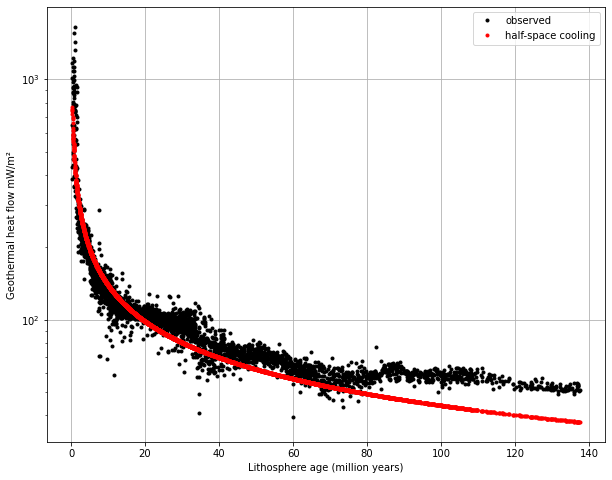

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(pacific_coarse.lithosphere_age.values.ravel(), pacific_coarse.heat_flow.values.ravel(), ".k", label="observed")
plt.plot(pacific_coarse.lithosphere_age.values.ravel(), predicted_heat_flow.values.ravel(), ".r", label="half-space cooling")
plt.legend()
plt.yscale("log")
plt.xlabel("Lithosphere age (million years)")
plt.ylabel("Geothermal heat flow mW/m²")
plt.grid()

## Bathymetry from half-space cooling

Now let's predict bathymetry and see how well it fits our data. Here is the equation for bathymetry again:

$$
w(t) = w_r + \dfrac{2 \rho_a \alpha_V (T_a - T_0)}{\rho_a - \rho_w} \sqrt{\dfrac{\alpha t}{\pi}}
$$

In this case, the units we'll consider are:

| Name | Variable | Unit |
|--:|:--:|:--|
| Bathymetry | $$w$$ | $$m$$ | 
| Ridge depth | $$w_r$$ | $$m$$ | 
| Density of water | $$\rho_w$$ | $$\frac{kg}{m^3}$$ | 
| Density of asthenosphere | $$\rho_a$$ | $$\frac{kg}{m^3}$$ | 
| Thermal diffusivity | $$\alpha$$ | $$\frac{mm^2}{s}$$ | 
| Age of the lithosphere | $$t$$ | $$myr = 10^6\ \text{years}$$ | 
| Asthenosphere temperature | $$T_a$$ | $$K$$ | 
| Surface temperature | $$T_0$$ | $$K$$ | 
| Thermal expansion coefficient | $$\alpha_V$$ | $$K^{-1}$$ | 

----

## **Your turn!**

In groups:

1. Finish the code for the `halfspace_bathymetry` function. 
1. Use your function to predict observations using the input parameters in the table below.
1. Plot your model predictions against the observed data.

|Input parameters|
|--|
|$$w_r = 2500\ m$$|
|$$\rho_w = 1000\ \frac{kg}{m^3}$$|
|$$\rho_a = 3300\ \frac{kg}{m^3}$$|
|$$T_0 = 273\ K$$|
|$$T_a = 1600\ K$$|
|$$\alpha = 1\ \frac{mm^2}{s}$$|
|$$\alpha_V = 3\cdot 10^{-5}\ K^{-1}$$|

Discuss the following points based on the results you've obtained so far:

* How well does the model fit both observations?
* Is the fit equal across all lithosphere ages?
* What does this say about the model and the way that the lithosphere changes with age?

Take notes and prepare to share a summary of your discussion with the class.

As a bonus (if you have time), select data from a different mid-ocean ridge system and check if the results are compatible. In other words, are these results universal or specific to this spreading center in the Pacific? For example, these coordinates will get a slice of the Atlantic: longitude between -30 and 5 and latitude between -50 and 0.


In [13]:
def halfspace_bathymetry(
    age, 
    ridge_depth, 
    asthenosphere_density, 
    water_density, 
    surface_temperature, 
    asthenosphere_temperature, 
    thermal_expansion, 
    diffusivity,
):
    """
    Bathymetry from the half-space cooling model.
    """
    # Get everything into compatible units first
    
   

    
    bathymetry = (
        
        
        
    )
    # -1 because the equation gives us thickness of the water layer
    return -1 * bathymetry    